In [9]:
#necessary imports for data manipulation  and visualization

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL
import pickle
import random
from math import sqrt, floor
from prettytable import PrettyTable

# to interact with the operating system
import os
import shutil
import pathlib

# sklearn
from sklearn.utils import class_weight
from sklearn.metrics import classification_report

# for computer vision
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras import models, layers, callbacks
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

import keras.utils as image
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras import metrics
from keras.callbacks import TensorBoard
import datetime
import time

In [11]:
#locating training and testing images folder

In [12]:
spath = "images/"

full_set = "images/data/train"
test_set = "images/data/test"
training_set = "images/train"
validation_set = "images/validation"

In [13]:
data_dir = pathlib.Path(full_set)
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2637


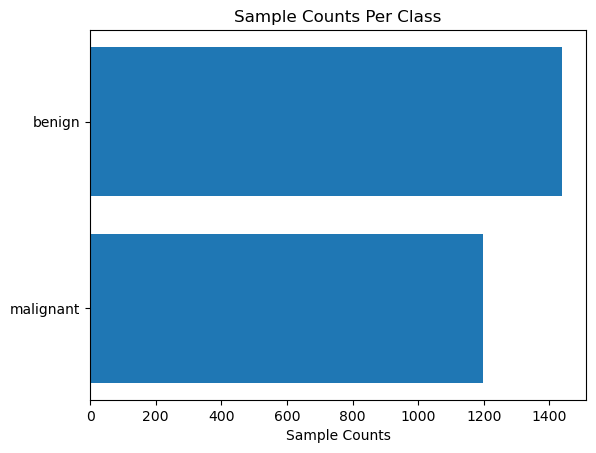

In [14]:
classes= []
sample_counts= []

for f in os.listdir(full_set):
    train_class_path= os.path.join(full_set, f)
    if os.path.isdir(train_class_path):
        classes.append(f)
        sample_counts.append(len(os.listdir(train_class_path)))

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(classes))

ax.barh(y_pos, sample_counts, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(classes)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Sample Counts')
ax.set_title('Sample Counts Per Class')

plt.show()

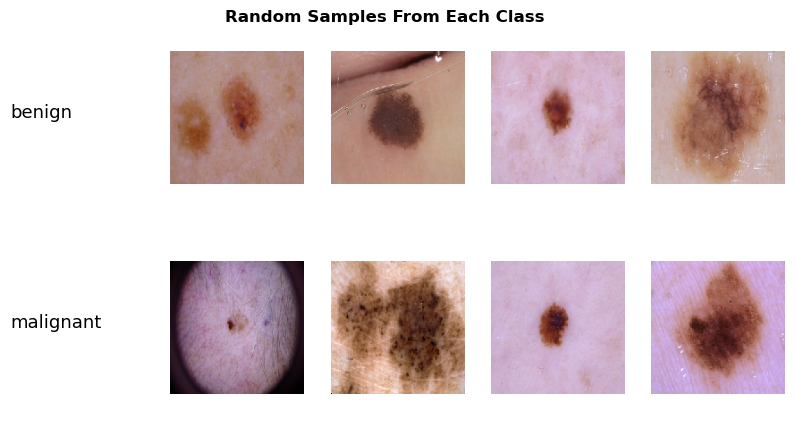

In [15]:
fig= plt.figure(figsize= (10, 5))
fig.suptitle('Random Samples From Each Class', fontsize=12, y=.92, horizontalalignment='center', weight='bold')

columns = 5
rows = 2
for i in range(2):
    sample_class= os.path.join(full_set,classes[i])
    for j in range(1,6):
        fig.add_subplot(rows, columns, i*5+j)
        plt.axis('off')
        if j==1:
            plt.text(0.0, 0.5,str(classes[i]).replace(' ','\n'), fontsize=13, wrap=True)
            continue
        random_image= os.path.join(sample_class, random.choice(os.listdir(sample_class)))
        #from keras.preprocessing.image
        img = image.load_img(random_image, target_size=(150, 150))
        img= image.img_to_array(img)
        img/=255.
        plt.imshow(img)

plt.show()

In [16]:
def create_validation(validation_split=0.1):
    if os.path.isdir(validation_set):
        print('Validation directory already created!')
        print('Process Terminated')
        return
    os.mkdir(validation_set)
    for f in os.listdir(training_set):
        train_class_path= os.path.join(training_set, f)
        if os.path.isdir(train_class_path):
            validation_class_path= os.path.join(validation_set, f)
            os.mkdir(validation_class_path)
            files_to_move= int(0.1*len(os.listdir(train_class_path)))
            
            for i in range(files_to_move):
                random_image= os.path.join(train_class_path, random.choice(os.listdir(train_class_path)))
                shutil.move(random_image, validation_class_path)
    print('Validation set created successfully using {:.2%} of training data'.format(validation_split))
create_validation()

Validation directory already created!
Process Terminated


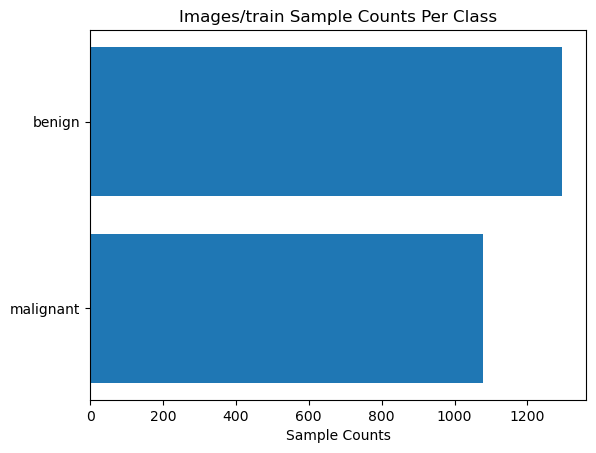

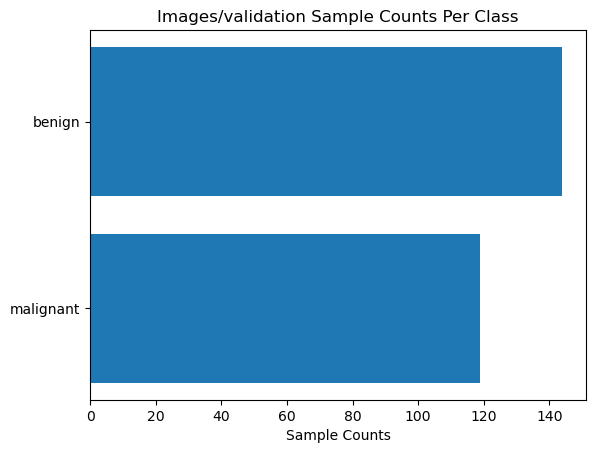

In [17]:
sample_counts= {}

for i, d in enumerate([training_set, validation_set]):

    classes= []
    sample_counts[d]= []

    for f in os.listdir(d):
        train_class_path= os.path.join(d, f)
        if os.path.isdir(train_class_path):
            classes.append(f)
            sample_counts[d].append(len(os.listdir(train_class_path)))

    fig, ax = plt.subplots()

    # Example data
    y_pos = np.arange(len(classes))

    ax.barh(y_pos, sample_counts[d], align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(classes)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Sample Counts')
    ax.set_title('{} Sample Counts Per Class'.format(d.capitalize()))

plt.show()

In [18]:
def print_bold(text):
    print('\033[1m{}\033[0m'.format(text))

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        
        dir_name= '{}{}/'.format(indent, os.path.basename(root))
        if dir_name.strip().startswith('.'):
            continue
        
        print_bold('\n'+dir_name)
            
        subindent = ' ' * 4 * (level + 1)
        if level==0:
            for f in files:
                if f.startswith('.'):
                    continue
                print('{}{}'.format(subindent, f))
        else:
            for i, f in enumerate(files):
                print('{}{}'.format(subindent, f))
                if i==2:
                    print('{}{}'.format(subindent, '...'))
                    break

list_files(spath)


/

data/

    test/

        benign/
            1.jpg
            10.jpg
            1003.jpg
            ...

        malignant/
            1.jpg
            1003.jpg
            1005.jpg
            ...

    train/

        benign/
            100.jpg
            1000.jpg
            1001.jpg
            ...

        malignant/
            10.jpg
            100.jpg
            1000.jpg
            ...

test/

    benign/
        1.jpg
        10.jpg
        1003.jpg
        ...

    malignant/
        1.jpg
        1003.jpg
        1005.jpg
        ...

train/

    benign/
        100.jpg
        1000.jpg
        1001.jpg
        ...

    malignant/
        10.jpg
        100.jpg
        1000.jpg
        ...

validation/

    benign/
        1008.jpg
        1010.jpg
        1011.jpg
        ...

    malignant/
        1002.jpg
        1011.jpg
        1050.jpg
        ...


In [19]:
batch_size = 32
img_height = 180
img_width = 180

In [20]:
# training set

training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_set,
    labels="inferred",
    label_mode="int",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size  = batch_size
)

Found 2374 files belonging to 2 classes.


In [21]:
# validation set

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_set,
    labels="inferred",
    label_mode="int",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size  = batch_size
)


Found 263 files belonging to 2 classes.


In [22]:
class_names = training_dataset.class_names
print(class_names)

['benign', 'malignant']


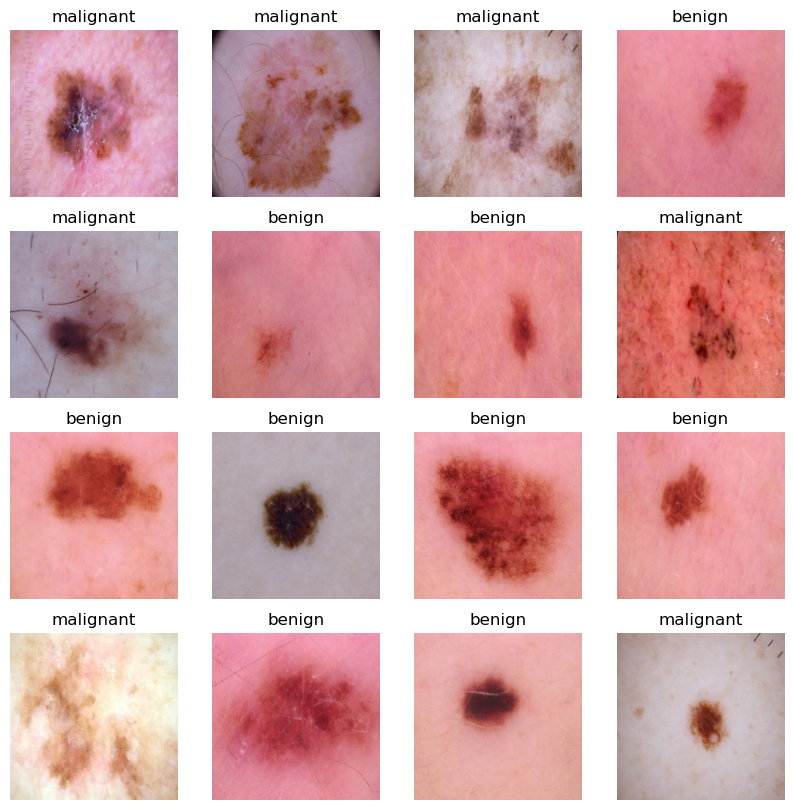

In [23]:
plt.figure(figsize=(10,10))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [24]:
for image_batch, labels_batch in training_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [27]:
normalized_ds = training_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.18498178 0.881024


In [28]:
num_classes = 2

model = Sequential([
                    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes),
                    ])

In [29]:
opt= keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)
model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [31]:
checkpoint_loc = "training_checkpoints/cp-ini-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_loc)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True,verbose=1)

In [32]:
epochs = 10
history = model.fit(training_dataset,validation_data=validation_dataset,epochs=epochs,callbacks=[cp_callback])

Epoch 1/10
75/75 [==============================] - ETA: 0s - loss: 0.5526 - accuracy: 0.7178
Epoch 1: saving model to training_checkpoints
75/75 [==============================] - 72s 940ms/step - loss: 0.5526 - accuracy: 0.7178 - val_loss: 0.4599 - val_accuracy: 0.7681
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.4220 - accuracy: 0.7793
Epoch 2: saving model to training_checkpoints
75/75 [==============================] - 83s 1s/step - loss: 0.4220 - accuracy: 0.7793 - val_loss: 0.4256 - val_accuracy: 0.8175
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8126
Epoch 3: saving model to training_checkpoints
75/75 [==============================] - 77s 1s/step - loss: 0.3794 - accuracy: 0.8126 - val_loss: 0.4812 - val_accuracy: 0.7795
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.3504 - accuracy: 0.8315
Epoch 4: saving model to training_checkpoints
75/75 [==============================] - 61s 820ms

In [33]:
# saving the model

!mkdir -p trained_models
model.save('trained_model/initial_run')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file trained_models already exists.
Error occurred while processing: trained_models.


INFO:tensorflow:Assets written to: trained_model/initial_run\assets


INFO:tensorflow:Assets written to: trained_model/initial_run\assets


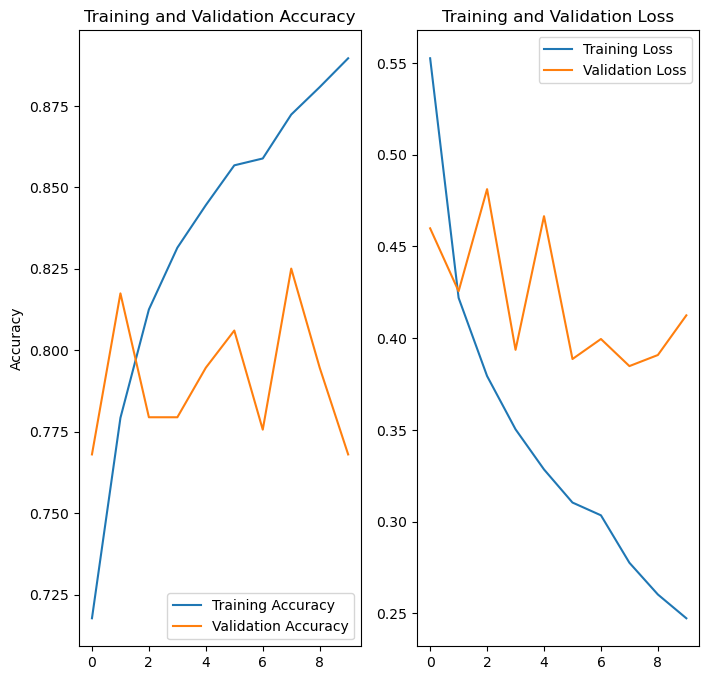

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [35]:
class_weights={}
samples = {}

samples_directory = os.listdir(training_set)

for cancertype in samples_directory:
  samples_path = os.path.join(training_set,cancertype)
  sameples_per_cancer = 0
  for acfilename in os.listdir(samples_path):
    sameples_per_cancer += 1
  samples[cancertype] = 1.0/sameples_per_cancer

norm_factor= np.mean(list(samples.values()))

cnamint = 0
for key, value in samples.items():
  class_weights[cnamint] = value/norm_factor
  cnamint += 1

print(class_weights)

t = PrettyTable(['class_index', 'class_weights'])
for i in sorted(class_weights.keys()):
    t.add_row([i, '{:.2f}'.format(class_weights[i])])
print(t)

{0: 0.9081718618365626, 1: 1.0918281381634372}
+-------------+---------------+
| class_index | class_weights |
+-------------+---------------+
|      0      |      0.91     |
|      1      |      1.09     |
+-------------+---------------+


In [36]:
data_augmentation = keras.Sequential(
    [
     tf.keras.layers.experimental.preprocessing.RandomFlip("vertical", input_shape=(img_height,img_width,3)),
     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
     tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [37]:
aug_model = Sequential([
  data_augmentation,

  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dropout(0.4),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.4),
  
  layers.Dense(num_classes)
])

In [38]:
opt= keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)
aug_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [39]:
aug_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [40]:
#checkpoint_loc_final = "training_checkpoints/cp-aug-{epoch:04d}.ckpt"
#checkpoint_dir_final = os.path.dirname(checkpoint_loc_final)
#fina_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir_final,save_weights_only=True,verbose=1)

best_cb= callbacks.ModelCheckpoint('model_best.h5', 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=True, 
                                         save_weights_only=False, 
                                         mode='auto')

In [41]:
epochs = 15
#aug_history = aug_model.fit(training_dataset,validation_data=validation_dataset,steps_per_epoch= 190,epochs=epochs,class_weight=class_weights,callbacks=[fina_callback])

aug_history = aug_model.fit(
                    training_dataset,
                    class_weight= class_weights,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    verbose=1,
                    callbacks= [best_cb])

Epoch 1/15


75/75 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.5299
Epoch 1: val_loss improved from inf to 0.69585, saving model to model_best.h5
75/75 [==============================] - 99s 1s/step - loss: 0.7920 - accuracy: 0.5299 - val_loss: 0.6959 - val_accuracy: 0.4525
Epoch 2/15
75/75 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.5918
Epoch 2: val_loss improved from 0.69585 to 0.66535, saving model to model_best.h5
75/75 [==============================] - 99s 1s/step - loss: 0.6638 - accuracy: 0.5918 - val_loss: 0.6654 - val_accuracy: 0.6958
Epoch 3/15
75/75 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7405
Epoch 3: val_loss improved from 0.66535 to 0.61809, saving model to model_best.h5
75/75 [==============================] - 94s 1s/step - loss: 0.5348 - accuracy: 0.7405 - val_loss: 0.6181 - val_accuracy: 0.6844
Epoch 4/15
75/75 [==============================] - ETA: 0s - loss: 0.4772 - accuracy: 0.7624
Epoch 

In [42]:
#load best model from training
from keras.models import load_model
aug_model = load_model('model_best.h5')
#aug_model= aug_model.load_model('model_best.h5')

In [43]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(aug_history.history) 

# save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

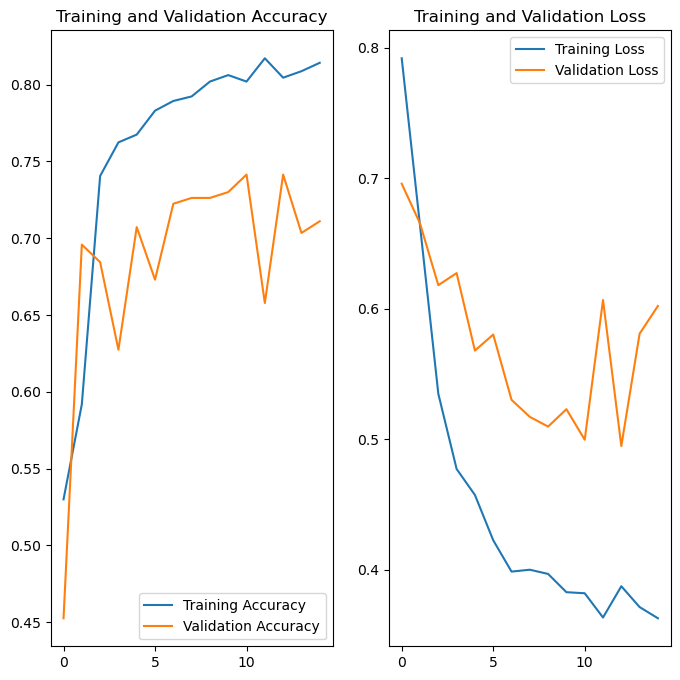

In [44]:
acc = aug_history.history['accuracy']
val_acc = aug_history.history['val_accuracy']

loss = aug_history.history['loss']
val_loss = aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Benign

In [45]:
testcancer_image = "images/data/test/benign/389.jpg"

img = keras.preprocessing.image.load_img(
    testcancer_image, target_size = (img_height,img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = aug_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

testimg = cv2.imread(testcancer_image, cv2.IMREAD_ANYCOLOR)

cv2.imshow("testimage", testimg)

print(
    "This cancer is of type {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 [==============================] - 0s 371ms/step
This cancer is of type benign with a 81.04 percent confidence.


# Malignant

In [46]:
test_images = "images/data/test/malignant/"

flist =os.listdir(test_images)
testcancer_image =random.choice(flist)
testcancer_image =os.path.join(test_images, testcancer_image)

img = keras.preprocessing.image.load_img(
    testcancer_image, target_size = (img_height,img_width)
)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = aug_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

testimg = cv2.imread(testcancer_image, cv2.IMREAD_ANYCOLOR)

cv2.imshow("testimage", testimg)

print(
    "This cancer is of type {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)],100 * np.max(score))
)

1/1 [==============================] - 0s 38ms/step
This cancer is of type malignant with a 64.19 percent confidence.


# Model Prediction

In [47]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [62]:
#load and preprocess the image for prediction
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image

img_pred=keras.preprocessing.image.load_img('images/t/21.jpg', target_size=(180,180))

img_pred=keras.preprocessing.image.img_to_array(img_pred)
img_pred=np.expand_dims(img_pred,axis=0)

rslt=model.predict(img_pred)

print(rslt)
if rslt[0][0]>rslt[0][1]:
    prediction="Benign"
    
else:
    prediction="Malignant"

print(prediction)


1/1 [==============================] - 0s 31ms/step
[[ 2.7830143 -3.6755867]]
Benign


In [ ]:
#load the trained model